# Aim

Just get Zernikes to fit

In [1]:
import eleanor
import numpy as np
import lightkurve as lk
from matplotlib import pyplot as plt
import tqdm
import scipy.optimize as sopt
from scipy.special import iv
from zernike import RZern, FitZern
import torch
from torch.autograd import grad as tgrad
from copy import deepcopy
%load_ext autoreload
%autoreload 2

In [2]:
# first, step 1: surgically extract code from afeinstein20/eleanor/master that still operates with my new API
star = eleanor.Source(tic=120362128, sector=14, tc=True)
star.premade = False
sc = lk.search_targetpixelfile(target='tic120362128', sector=14).download()
sq = sc.quality < 5000
start = 2500
end = 3400
time = sc.time[sq][start:end].value
tpfs = sc.flux[sq][start:end].value
errs = sc.flux_err[sq][start:end].value
bkgs = sc.flux_bkg[sq,0,0][start:end].value
bkg0 = np.mean(bkgs)
data = eleanor.TargetData(
    star, 
    height=11, 
    width=11, 
    do_pca=True,
    do_psf=False,
)
sources_in_tpf = eleanor.mast.gaia_sources_in_tpf(star, 10, tpfs.shape[1:])
xc = np.array(sources_in_tpf.coords_x) + tpfs.shape[2] / 2
yc = np.array(sources_in_tpf.coords_y) + tpfs.shape[1] / 2
x, y = np.meshgrid(range(-58, 59), range(-58, 59)) 

In [3]:
star

In [4]:
data

In [16]:
prf

NameError: name 'prf' is not defined

In [15]:
data_g.psf_params

[autoreload of eleanor.models failed: Traceback (most recent call last):
  File "/Users/adityasengupta/opt/anaconda3/envs/eleanorupgrade/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/adityasengupta/opt/anaconda3/envs/eleanorupgrade/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/adityasengupta/opt/anaconda3/envs/eleanorupgrade/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Users/adityasengupta/opt/anaconda3/envs/eleanorupgrade/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/Users/adityasengupta/opt/anaconda3/envs/eleanorupgrade/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)


array([[ 0.68893997, -0.03068274,  0.75483393],
       [ 0.68430474, -0.02905532,  0.75123499],
       [ 0.67741943, -0.02898716,  0.75196801],
       ...,
       [ 0.68881448, -0.02872933,  0.7502501 ],
       [ 0.68862803, -0.02726841,  0.74911204],
       [ 0.68892086, -0.0307799 ,  0.75372242]])

In [30]:
data.psf_lightcurve(data_arr=tpfs, err_arr=errs, bkg_arr=bkgs, model_name='Zernike', verbose=True, bkg_mag_cutoff=10, ignore_pixels=1)

[autoreload of eleanor.models failed: Traceback (most recent call last):
  File "/Users/adityasengupta/opt/anaconda3/envs/eleanorupgrade/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/adityasengupta/opt/anaconda3/envs/eleanorupgrade/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/adityasengupta/opt/anaconda3/envs/eleanorupgrade/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Users/adityasengupta/opt/anaconda3/envs/eleanorupgrade/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/Users/adityasengupta/opt/anaconda3/envs/eleanorupgrade/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)


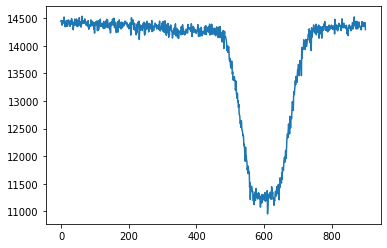

In [31]:
plt.plot(data.psf_flux[:,1])

In [10]:
data_g = deepcopy(data)

In [12]:
data_g.psf_lightcurve(data_arr=tpfs, err_arr=errs, bkg_arr=bkgs, model_name='Gaussian', verbose=True, bkg_mag_cutoff=10, ignore_pixels=1)

100%|██████████| 900/900 [01:03<00:00, 14.24it/s]


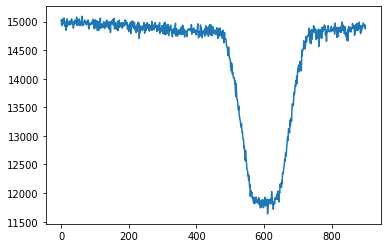

In [13]:
plt.plot(data_g.psf_flux[:,1])

Text(0.5, 1.0, 'PSF-corrected light curves for crowded field (TIC 120362128)')

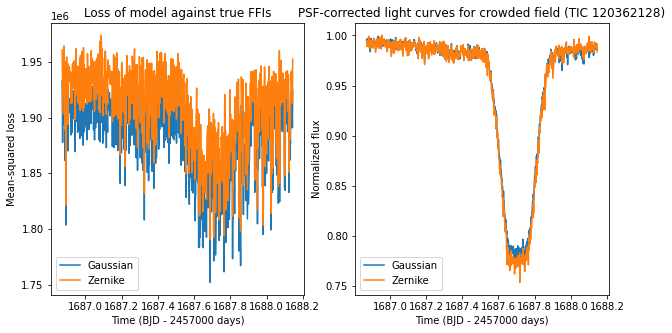

In [32]:
f, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].plot(time, data_g.psf_ll, label='Gaussian')
ax[0].plot(time, data.psf_ll, label='Zernike')
ax[0].legend()
ax[0].set_xlabel("Time (BJD - 2457000 days)")
ax[0].set_ylabel("Mean-squared loss")
ax[0].set_title("Loss of model against true FFIs")
ax[1].plot(time, data_g.psf_flux[:,1] / np.max(data_g.psf_flux[:,1]), label='Gaussian')
ax[1].plot(time, data.psf_flux[:,1] / np.max(data.psf_flux[:,1]), label='Zernike')
ax[1].legend()
ax[1].set_xlabel("Time (BJD - 2457000 days)")
ax[1].set_ylabel("Normalized flux")
ax[1].set_title("PSF-corrected light curves for crowded field (TIC 120362128)")
# plt.savefig('./compare_lc.png')

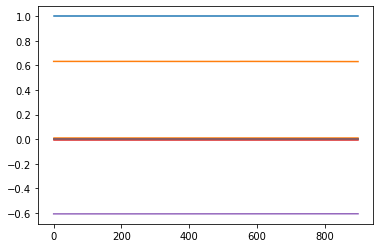

In [161]:
plt.plot(data.psf_params)

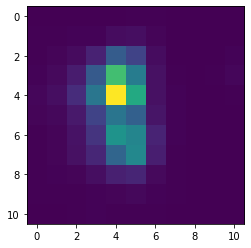

In [110]:
plt.imshow(tpfs[0])

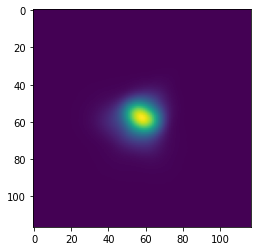

In [111]:
plt.imshow(prf)

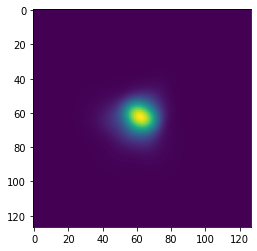

In [112]:
from scipy.signal import convolve2d
plt.imshow(convolve2d(prf, tpfs[0]))

In [129]:
1 - np.mean(data.psf_ll) / np.mean(data_g.psf_ll)

AttributeError: 'TargetData' object has no attribute 'psf_ll'

In [25]:
lk.estimate_cdpp(data.psf_flux[:,1]).value

8518.081068173607

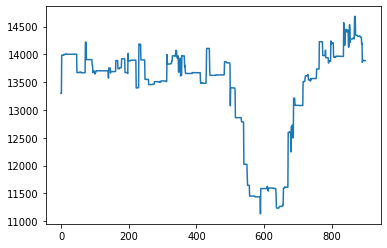

In [28]:
plt.plot(data.psf_flux[:,1])

In [169]:
data.psf_params[0]

array([ 1.00000000e+00,  6.32472869e-01, -1.44048192e-03, -2.82599191e-03,
       -6.08317986e-01,  4.20081374e-03, -2.84860087e-03, -9.19980142e-04,
        2.24813244e-03,  1.55329483e-04,  1.08086588e-03,  1.27810881e-02,
        2.64896892e-03, -4.85427269e-03, -1.30814597e-04, -9.55529364e-04])

In [278]:
zernmodel = eleanor.models.Zernike(
    shape=(11,11),
    col_ref=0,
    row_ref=0,
    xc=xc,
    yc=yc,
    bkg0=bkg0,
    loss=None,
    source=star
)

In [260]:
zernmodel.mode_mask

array([1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0])

In [19]:
prf = eleanor.make_prf_from_source(star)

In [57]:
zern = RZern(6)

In [89]:
xtest, ytest = np.meshgrid(np.arange(-5, 6), np.arange(-5, 6))
rhotest, thetatest = np.sqrt(xtest ** 2 + ytest ** 2), np.arctan2(ytest, xtest)

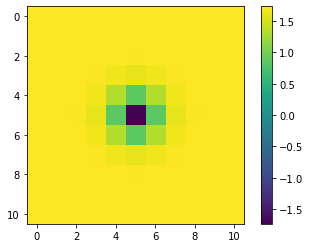

In [130]:
plt.imshow(zern.radial(3, 1 - np.exp(-rhotest/0.5)))
plt.colorbar()

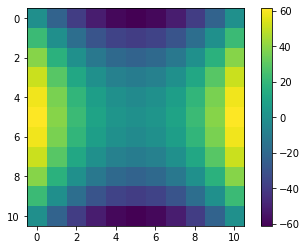

In [143]:
k = 5
plt.imshow(zern.angular(k, thetatest) * zern.radial(k, rhotest))
plt.colorbar()